# Procesamiento Digital de Señales (DSP) — Ejemplos básicos en Python
Este notebook muestra conceptos fundamentales de DSP con ejemplos prácticos en Python.

Temas incluidos:
- Muestreo y aliasing
- Transformada de Fourier (DFT/FFT)
- Convolución y sistemas LTI
- Filtros FIR e IIR
- Ventanas y leakage espectral
- Espectrograma (STFT)
- Correlación cruzada


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [3]:
def plot_time(t, x, title, xlim=None):
    plt.figure(figsize=(8,3))
    plt.plot(t, x)
    plt.title(title)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    if xlim is not None:
        plt.xlim(xlim)
    plt.grid(True)
    plt.show()

def plot_spectrum(x, fs, title):
    N = len(x)
    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(N, 1/fs)
    plt.figure(figsize=(8,3))
    plt.plot(freqs, np.abs(X)/N)
    plt.title(title)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud (|X|/N)')
    plt.xlim(0, fs/2)
    plt.grid(True)
    plt.show()


## 1) Muestreo y aliasing

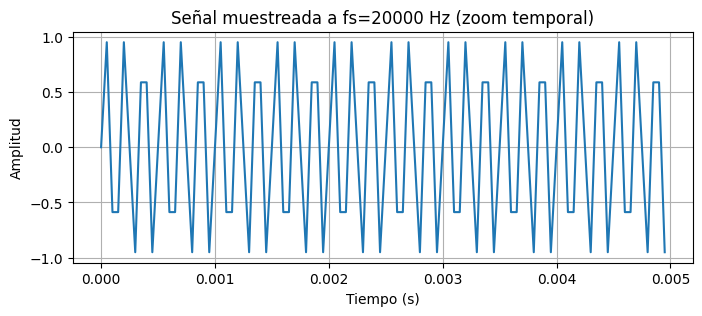

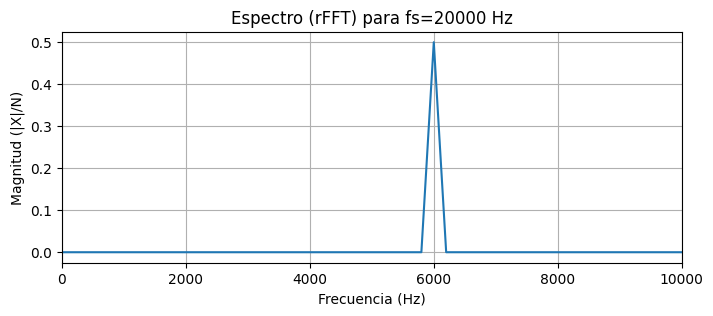

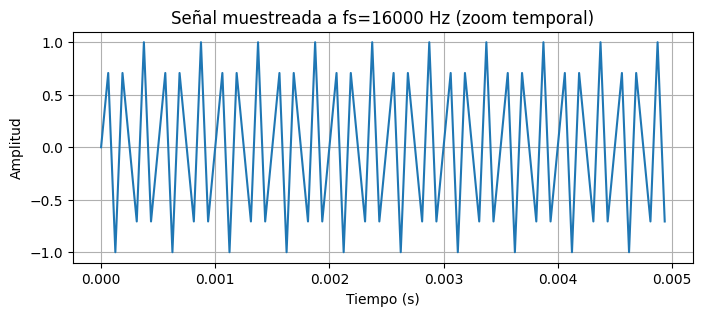

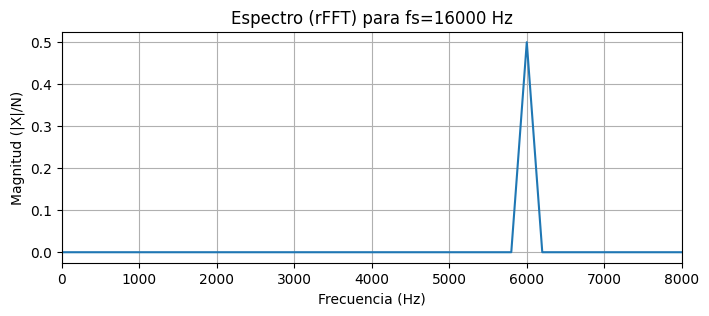

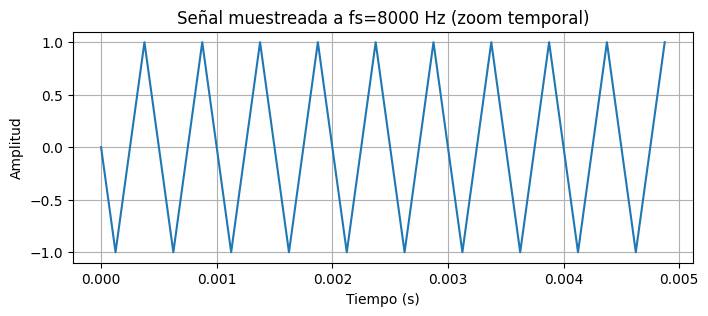

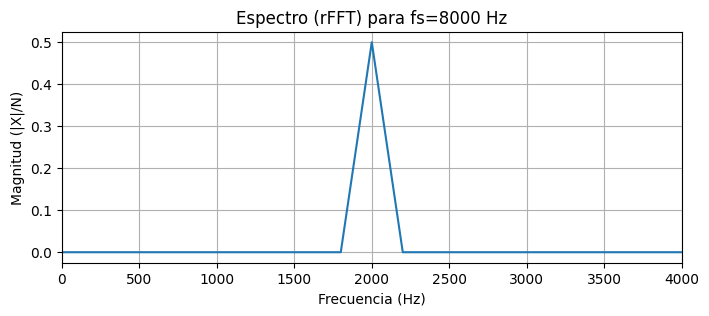

In [4]:
fs_high = 20000
t_high = np.arange(0, 0.005, 1/fs_high)
f_signal = 6000.0
x_high = np.sin(2*np.pi*f_signal*t_high)

fs_good = 16000
fs_bad  = 8000
for fs in (fs_high, fs_good, fs_bad):
    t = np.arange(0, 0.005, 1/fs)
    x = np.sin(2*np.pi*f_signal*t)
    plot_time(t[:200], x[:200], f"Señal muestreada a fs={fs} Hz (zoom temporal)")
    plot_spectrum(x, fs, f"Espectro (rFFT) para fs={fs} Hz")


## 2) DFT/FFT: resolución y zero-padding

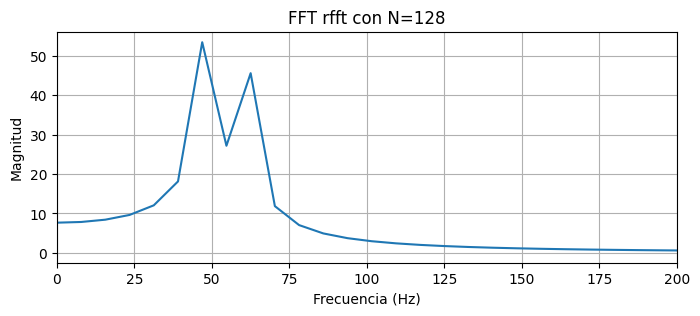

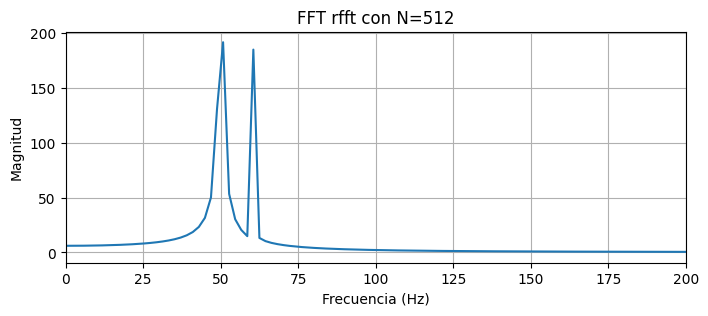

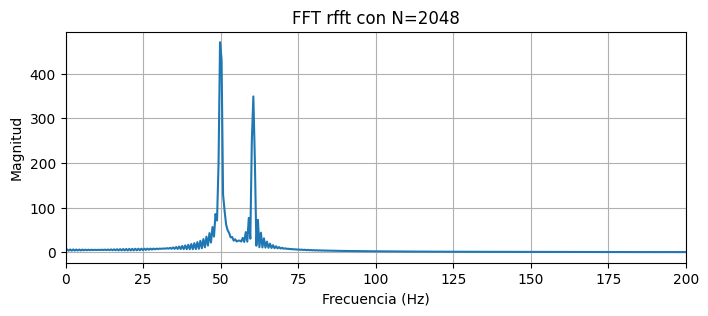

In [5]:
fs = 1000
t = np.arange(0, 1, 1/fs)
x = np.sin(2*np.pi*50*t) + 0.7*np.sin(2*np.pi*60.5*t)
for N in (128, 512, 2048):
    X = np.fft.rfft(x, n=N)
    freqs = np.fft.rfftfreq(N, 1/fs)
    plt.figure(figsize=(8,3))
    plt.plot(freqs, np.abs(X))
    plt.title(f"FFT rfft con N={N}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.xlim(0, 200)
    plt.grid(True)
    plt.show()


## 3) Convolución y sistemas LTI

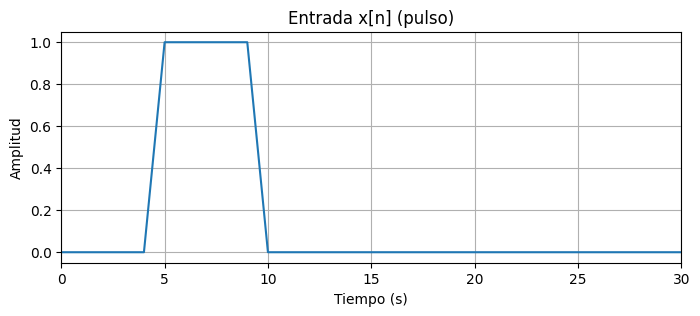

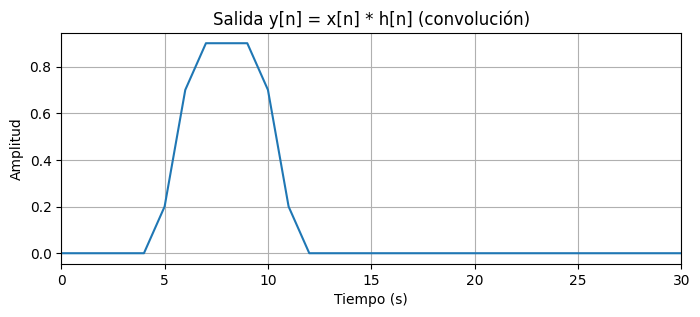

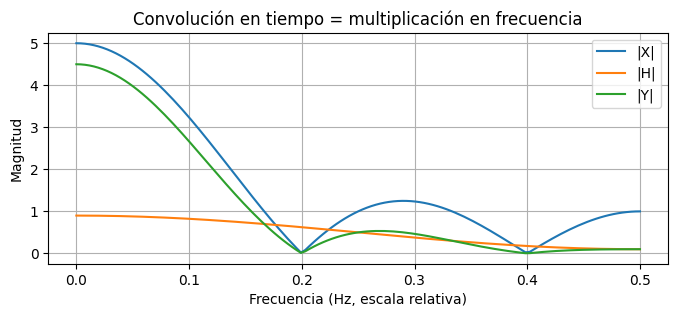

In [6]:
x = np.zeros(60)
x[5:10] = 1.0
h = np.array([0.2, 0.5, 0.2])
y = np.convolve(x, h)
t_x = np.arange(len(x))
t_y = np.arange(len(y))
plot_time(t_x, x, "Entrada x[n] (pulso)", xlim=(0,30))
plot_time(t_y, y, "Salida y[n] = x[n] * h[n] (convolución)", xlim=(0,30))

Nfft = 256
X = np.fft.rfft(x, n=Nfft)
H = np.fft.rfft(h, n=Nfft)
Y = np.fft.rfft(y, n=Nfft)
plt.figure(figsize=(8,3))
plt.plot(np.fft.rfftfreq(Nfft,1), np.abs(X), label='|X|')
plt.plot(np.fft.rfftfreq(Nfft,1), np.abs(H), label='|H|')
plt.plot(np.fft.rfftfreq(Nfft,1), np.abs(Y), label='|Y|')
plt.title("Convolución en tiempo = multiplicación en frecuencia")
plt.xlabel("Frecuencia (Hz, escala relativa)")
plt.ylabel("Magnitud")
plt.legend()
plt.grid(True)
plt.show()


## 4) Filtrado: FIR e IIR simple

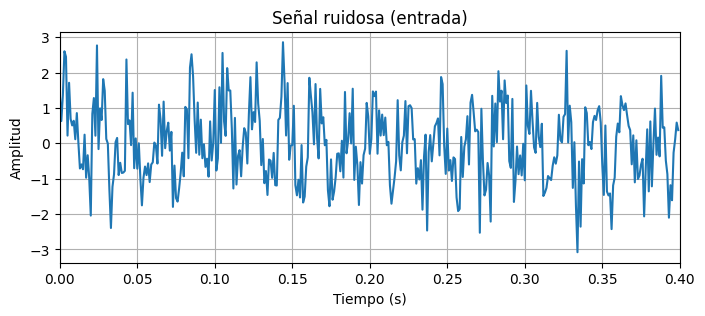

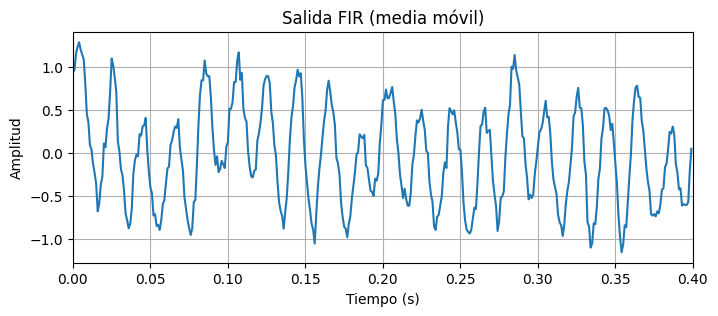

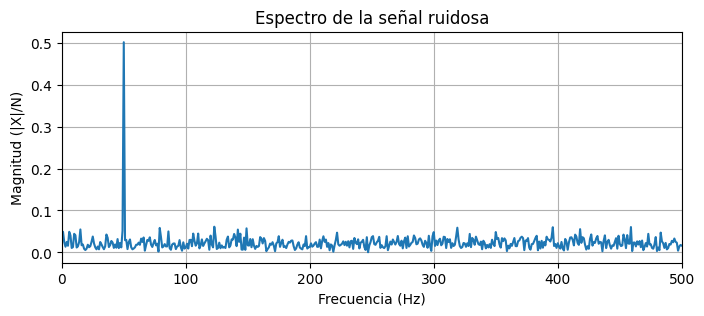

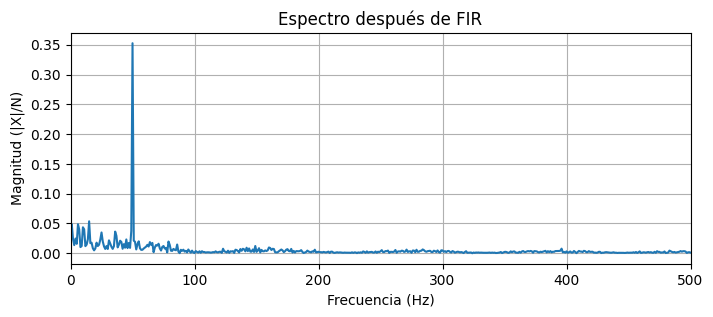

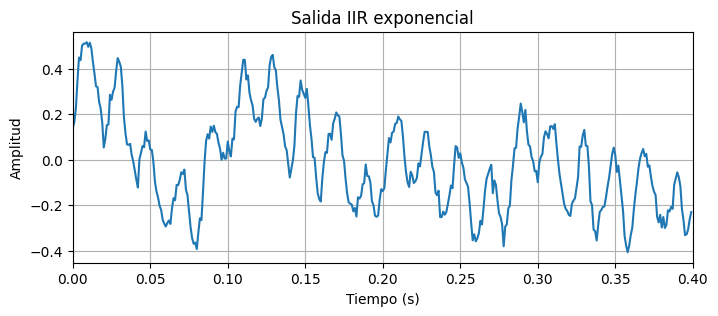

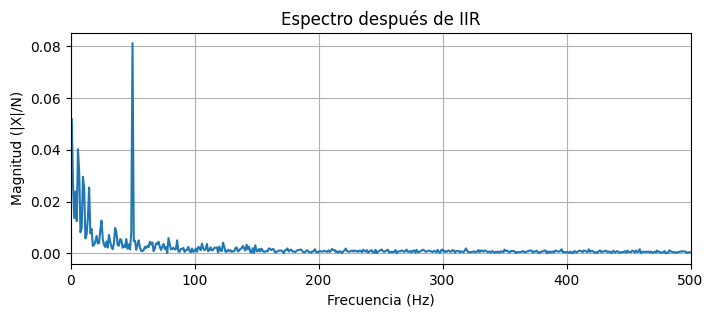

In [7]:
fs = 1000
t = np.arange(0, 1, 1/fs)
clean = np.sin(2*np.pi*50*t)
noise = 0.8*np.random.randn(len(t))
x_noisy = clean + noise

M = 9
h_fir = np.ones(M)/M
y_fir = np.convolve(x_noisy, h_fir, mode='same')

plot_time(t[:400], x_noisy[:400], "Señal ruidosa (entrada)", xlim=(0,0.4))
plot_time(t[:400], y_fir[:400], "Salida FIR (media móvil)", xlim=(0,0.4))
plot_spectrum(x_noisy, fs, "Espectro de la señal ruidosa")
plot_spectrum(y_fir, fs, "Espectro después de FIR")

alpha = 0.95
y_iir = np.zeros_like(x_noisy)
for n in range(len(x_noisy)):
    x_n = x_noisy[n]
    y_iir[n] = (1-alpha)*x_n + (alpha*y_iir[n-1] if n>0 else (1-alpha)*x_n)

plot_time(t[:400], y_iir[:400], "Salida IIR exponencial", xlim=(0,0.4))
plot_spectrum(y_iir, fs, "Espectro después de IIR")


## 5) Ventanas y leakage

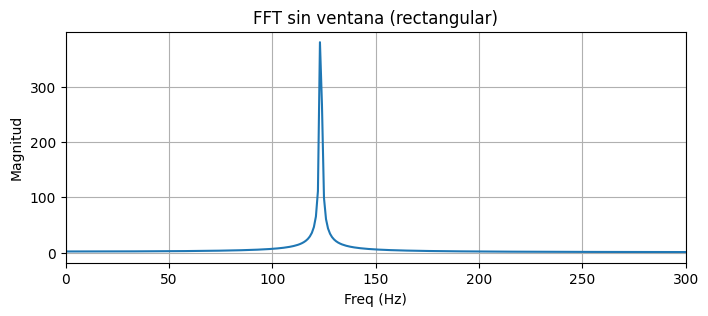

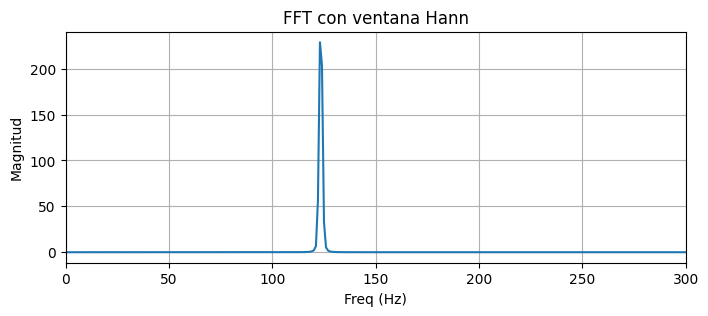

In [8]:
fs = 1000
N = 1024
t = np.arange(N)/fs
f_tone = 123.45
x_tone = np.sin(2*np.pi*f_tone*t)

X_rect = np.fft.fft(x_tone)
X_hann = np.fft.fft(x_tone * np.hanning(N))

freqs = np.fft.fftfreq(N, 1/fs)
pos = freqs[:N//2]

plt.figure(figsize=(8,3))
plt.plot(pos, np.abs(X_rect[:N//2]))
plt.title("FFT sin ventana (rectangular)")
plt.xlabel("Freq (Hz)")
plt.ylabel("Magnitud")
plt.xlim(0, 300)
plt.grid(True)
plt.show()

plt.figure(figsize=(8,3))
plt.plot(pos, np.abs(X_hann[:N//2]))
plt.title("FFT con ventana Hann")
plt.xlabel("Freq (Hz)")
plt.ylabel("Magnitud")
plt.xlim(0, 300)
plt.grid(True)
plt.show()


## 6) Espectrograma / STFT

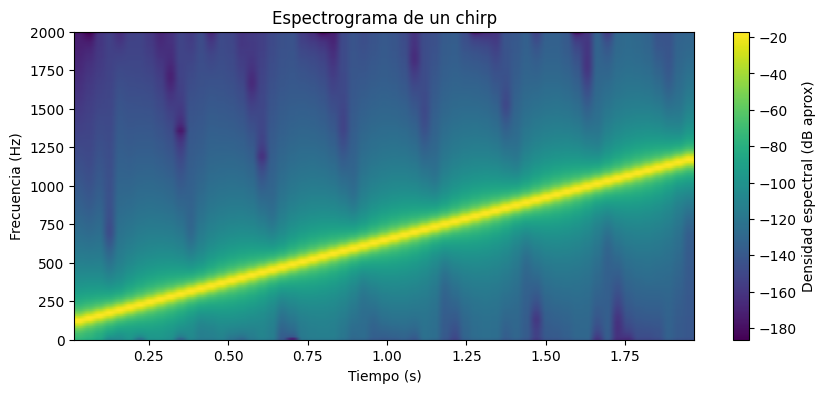

In [9]:
fs = 4000
T = 2.0
t = np.linspace(0, T, int(T*fs), endpoint=False)
f0, f1 = 100, 1200
k = (f1 - f0) / T
phase = 2*np.pi*(f0*t + 0.5*k*t**2)
x_chirp = np.sin(phase)

plt.figure(figsize=(10,4))
Pxx, freqs, bins, im = plt.specgram(x_chirp, NFFT=256, Fs=fs, noverlap=128)
plt.title("Espectrograma de un chirp")
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.colorbar(label='Densidad espectral (dB aprox)')
plt.show()


## 7) Correlación cruzada

Delay estimado (muestras) = 30
Delay estimado (segundos, fs=1000) = 0.0300 s


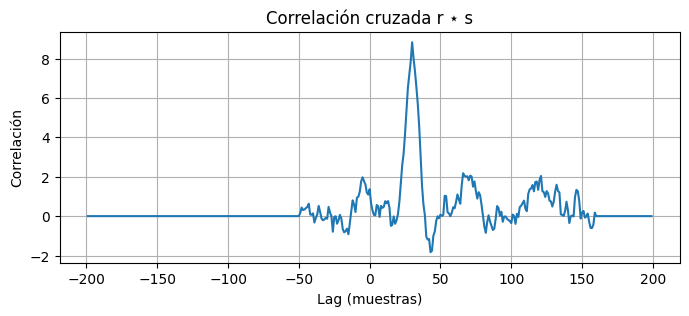

In [10]:
s = np.zeros(200)
s[40:50] = 1.0
delay = 30
r = np.roll(s, delay) + 0.3*np.random.randn(len(s))
xc = np.correlate(r, s, mode='full')
lags = np.arange(-len(s)+1, len(s))
est_delay = lags[np.argmax(xc)]
print(f"Delay estimado (muestras) = {est_delay}")
print(f"Delay estimado (segundos, fs=1000) = {est_delay/1000.0:.4f} s")

plt.figure(figsize=(8,3))
plt.plot(lags, xc)
plt.title("Correlación cruzada r ⋆ s")
plt.xlabel("Lag (muestras)")
plt.ylabel("Correlación")
plt.grid(True)
plt.show()
